# Brain Tumor Detection Using a Convolutional Neural Network

## Importing

In [1]:
import tensorflow as tf #for machine learning library 
from keras.preprocessing.image import ImageDataGenerator #keras is api for mahcine learning, imagedatagenerator is 
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint #tensorboard is for data visualization, modelcheckpoint is keeping log of parameters during training.
from sklearn.model_selection import train_test_split #for splitting the dataset into train test split
from sklearn.metrics import f1_score #for getting metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle #shuffles the dataset
import cv2 #computer vision used for performing color operations on images.
import imutils #used for performing image processing function like rotate, resizing
import numpy as np # mathematical ops
import matplotlib.pyplot as plt #for plotting graphs
import time #for time keeping
from os import listdir #used for getting files stored on our computer
import pickle
%matplotlib inline

## Data Prep & Preproc

In [2]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #converts to grayscale, rgb colors are not relevant here in detecting tumors.
    gray = cv2.GaussianBlur(gray, (5, 5), 0) #adds gaussian blur to image to smoothen it and remove some noise

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    #each pixel value is compared with the threshold value. If the pixel value is smaller than the threshold, it is set to 0, otherwise, it is set to a maximum value.
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1] #used to seperate background pixels from foreground pixels
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)# erode and dilate noise removal oprn

    # Find contours in thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

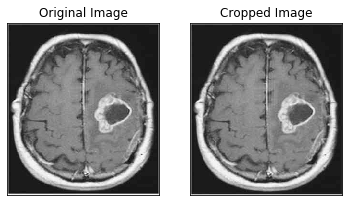

In [3]:
ex_img = cv2.imread('yes/Y10.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

In [4]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [5]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


### Plot sample images:

In [6]:
def plot_sample_images(X, y, n=50):
    
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

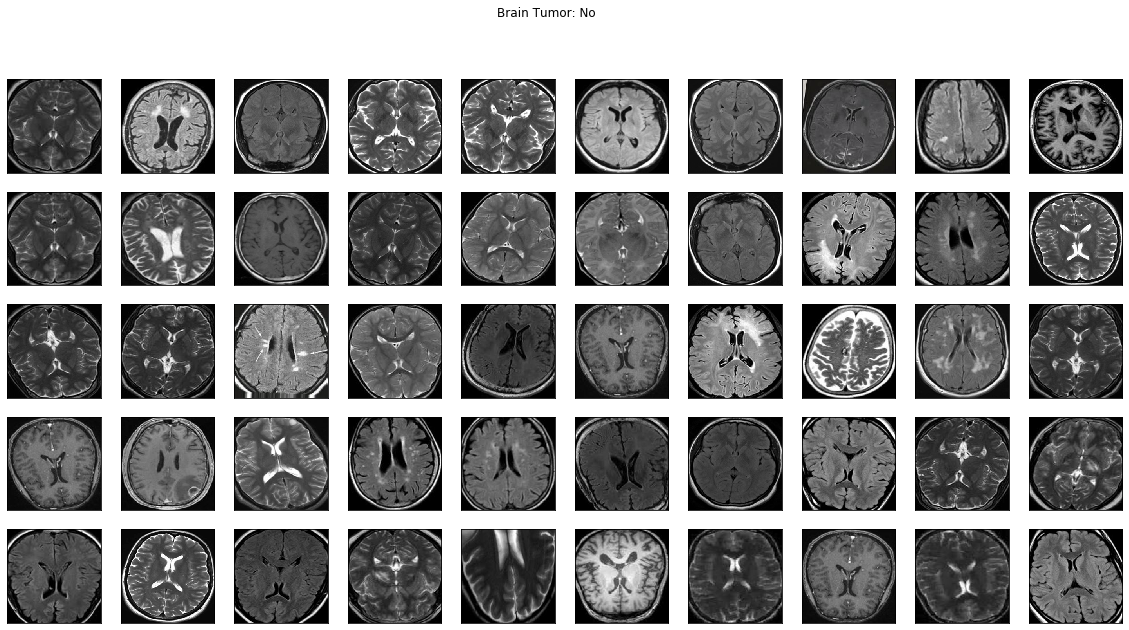

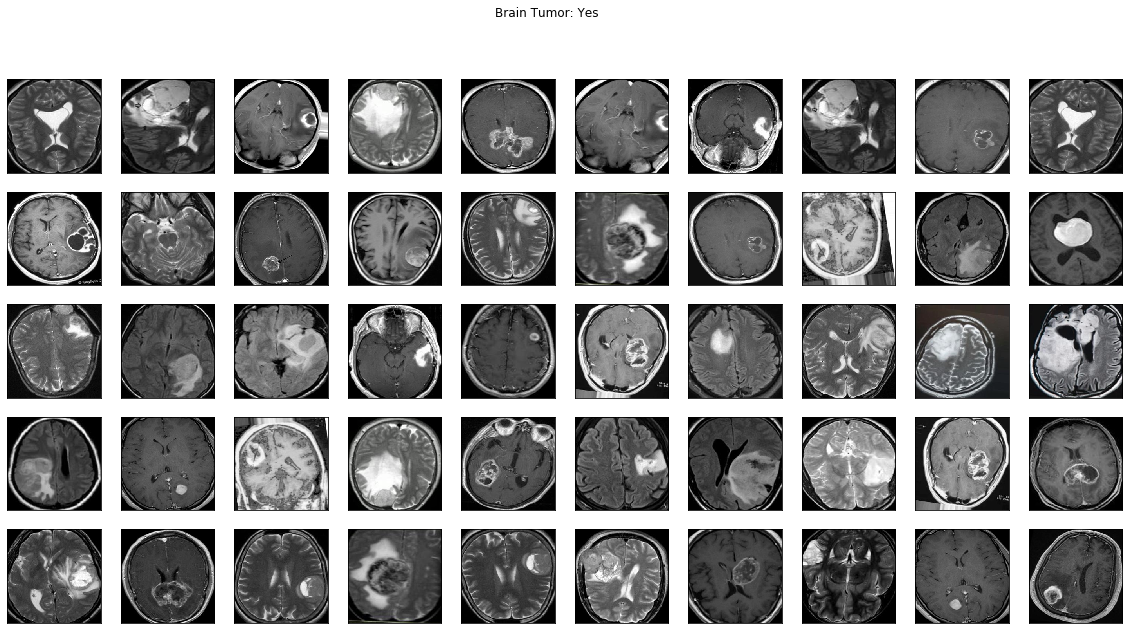

In [7]:
plot_sample_images(X, y)

### Split the data:


In [8]:
def split_data(X, y, test_size=0.2):
       
    
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [10]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [11]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [12]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Builld the modle

In [18]:
def build_model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    # X = Conv2D(42, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0',activation='relu')(X)
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv1',activation='relu')(X)
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv2',activation='relu')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    # X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, we usejd this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

#img shape:

In [19]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [20]:
model = build_model(IMG_SHAPE)

In [21]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 242, 242, 32)      896       
                                                                 
 conv1 (Conv2D)              (None, 240, 240, 32)      9248      
                                                                 
 conv2 (Conv2D)              (None, 238, 238, 32)      9248      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                               

Compile the model:

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [24]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Training the model

In [32]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - 182s 4s/step - loss: 0.5887 - accuracy: 0.7045 - val_loss: 0.6611 - val_accuracy: 0.6903
Epoch 2/10
46/46 [==============================] - 188s 4s/step - loss: 0.4165 - accuracy: 0.8159 - val_loss: 0.6336 - val_accuracy: 0.7677
Epoch 3/10
46/46 [==============================] - 185s 4s/step - loss: 0.4284 - accuracy: 0.8076 - val_loss: 0.6138 - val_accuracy: 0.6710
Epoch 4/10
46/46 [==============================] - 187s 4s/step - loss: 0.3248 - accuracy: 0.8630 - val_loss: 0.5705 - val_accuracy: 0.7774
Epoch 5/10
46/46 [==============================] - 189s 4s/step - loss: 0.2576 - accuracy: 0.8969 - val_loss: 0.5198 - val_accuracy: 0.8194
Epoch 6/10
46/46 [==============================] - 229s 5s/step - loss: 0.2339 - accuracy: 0.9073 - val_loss: 0.4758 - val_accuracy: 0.8290
Epoch 7/10
46/46 [==============================] - 231s 5s/step - loss: 0.2163 - accuracy: 0.9197 - val_loss: 0.4493 - val_accuracy: 0.8323
Epoch 8/10
46

In [33]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 228s 5s/step - loss: 0.1061 - accuracy: 0.9675 - val_loss: 0.3365 - val_accuracy: 0.8516
Epoch 2/3
46/46 [==============================] - 226s 5s/step - loss: 0.0607 - accuracy: 0.9882 - val_loss: 0.3658 - val_accuracy: 0.8516
Epoch 3/3
46/46 [==============================] - 198s 4s/step - loss: 0.0555 - accuracy: 0.9889 - val_loss: 0.4083 - val_accuracy: 0.8419
Elapsed time: 0:11:0.9


In [34]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 215s 5s/step - loss: 0.1542 - accuracy: 0.9391 - val_loss: 0.5009 - val_accuracy: 0.8258
Epoch 2/3
46/46 [==============================] - 191s 4s/step - loss: 0.1068 - accuracy: 0.9564 - val_loss: 0.3970 - val_accuracy: 0.8484
Epoch 3/3
46/46 [==============================] - 192s 4s/step - loss: 0.0397 - accuracy: 0.9910 - val_loss: 0.4548 - val_accuracy: 0.8677
Elapsed time: 0:10:3.9


In [35]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 198s 4s/step - loss: 0.0232 - accuracy: 0.9986 - val_loss: 0.4574 - val_accuracy: 0.8613
Epoch 2/3
46/46 [==============================] - 201s 4s/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.5078 - val_accuracy: 0.8516
Epoch 3/3
46/46 [==============================] - 192s 4s/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.4445 - val_accuracy: 0.8710
Elapsed time: 0:9:58.0


In [36]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
46/46 [==============================] - 198s 4s/step - loss: 0.0132 - accuracy: 1.0000 - val_loss: 0.4603 - val_accuracy: 0.8645
Epoch 2/5
46/46 [==============================] - 220s 5s/step - loss: 0.0134 - accuracy: 0.9993 - val_loss: 0.4683 - val_accuracy: 0.8710
Epoch 3/5
46/46 [==============================] - 204s 4s/step - loss: 0.0108 - accuracy: 0.9993 - val_loss: 0.5279 - val_accuracy: 0.8613
Epoch 4/5
46/46 [==============================] - 202s 4s/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.4940 - val_accuracy: 0.8806
Epoch 5/5
46/46 [==============================] - 210s 5s/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.5053 - val_accuracy: 0.8677
Elapsed time: 0:17:21.3


In [20]:
history = model.history.history

AttributeError: 'NoneType' object has no attribute 'history'

In [ ]:
for key in history.keys():
    print(key)

## Plt lss and accurcy

In [32]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [33]:
plot_metrics(history) 

NameError: name 'history' is not defined

# Results

### bemst model

In [13]:
from tensorflow.keras.models import Model, load_model
best_model = load_model(filepath='models/cnn-parameters-improvement-23-0.91.model')

In [14]:
best_model.metrics_names

['loss', 'accuracy']

Evaluate the best model on the testing data:

In [15]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 4s 306ms/step - loss: 0.1693 - accuracy: 0.9548


### Accuay of the best model on the testing d0ata:

In [16]:
#print (f"Test Loss = {val_loss}")
#print (f"Test Accuracy = {val_acc}")

In [17]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.1692919135093689
Test Accuracy = 0.9548386931419373


### F1 score for the model on the temting data:

In [18]:
y_test_prob = best_model.predict(X_test)

In [19]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9539473684210527


f1 score on the validation data:

In [20]:
y_val_prob = best_model.predict(X_val)

In [21]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9589905362776026


### Results 


In [23]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [24]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [25]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 53.28719723183391%, number of pos examples: 770
Percentage of negative examples: 46.71280276816609%, number of neg examples: 675
Validation Data:
Number of examples: 310
Percentage of positive examples: 51.61290322580645%, number of pos examples: 160
Percentage of negative examples: 48.38709677419355%, number of neg examples: 150
Testing Data:
Number of examples: 310
Percentage of positive examples: 50.0%, number of pos examples: 155
Percentage of negative examples: 50.0%, number of neg examples: 155


# conclusion:

**96%** accuracy on the **test set**.<br>
**0.96** f1 score on the **test set**.<br>


**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 91%            | 96%      |
| F1 score  | 0.95           | 0.96     |

[[1.]]
Brain Tumor Detected, 
 Advice: Consult Doctor


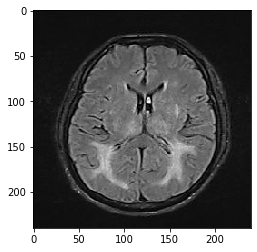

In [29]:
from keras.preprocessing import image
#from tensorflow.keras.utils import Sequence
img1 = image.load_img('yes/KokilabenAMBlbs3421Download.jpg',target_size=(240, 240))
plt.imshow(img1)
Y = image.img_to_array(img1)
X = np.expand_dims(Y,axis=0)
result = best_model.predict(X)
print(result)
if result == 1:
    print("Brain Tumor Detected, \n Advice: Consult Doctor")
elif result == 0:
    print("No Brain Tumor Detected, \n Advice: Normal Brain MRI")

In [31]:

from keras.preprocessing import image
#from tensorflow.keras.utils import Sequence
img1 = image.load_img('no/KokilabenAMBlbs187524Download.jpg',target_size=(240, 240))
plt.imshow(img1)
Y = image.img_to_array(img1)
X = np.expand_dims(Y,axis=0)
result = best_model.predict(X)
print(result)
if result == 1:
    print("Brain Tumor Detected, \n Advice: Consult Doctor")
elif result == 0:
    print("No Brain Tumor Detected, \n Advice: Normal Brain MRI")

FileNotFoundError: [Errno 2] No such file or directory: 'no/KokilabenAMBlbs187524Download.jpg'

In [42]:
import pickle
with open('btd.pkl', 'wb') as file:
    pickle.dump(best_model, file)

INFO:tensorflow:Assets written to: ram://62c084c3-ae5b-4923-b9f0-ef95ce854d42/assets


NotFoundError: 